# facebook data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
%matplotlib inline
from scipy import optimize

In [2]:
DATA_DIR = "./"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

In [3]:
def LoadData(data_filename, data_dir):
    '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
    return pd.read_csv(os.path.join(data_dir, data_filename))  

In [4]:
df_facebook_friends = LoadData(DATA_FILENAMES["facebook_friends"], DATA_DIR)
# data cleaning: removing self-friendships
df_facebook_friends = df_facebook_friends[df_facebook_friends["user_b"] != df_facebook_friends["# user_a"]]
print("\nfacebook friends\n", df_facebook_friends.head())

df_genders = LoadData(DATA_FILENAMES["genders"], DATA_DIR)
print("\ngenders\n", df_genders.head())


facebook friends
    # user_a  user_b
0         0     512
1         0     263
2         0     525
3         0     285
4         0     543

genders
    # user  female
0       0       0
1       2       0
2       3       0
3       4       0
4       5       0


Vedere se tutti i partecipanti hanno facebook e vedere il loro gender.

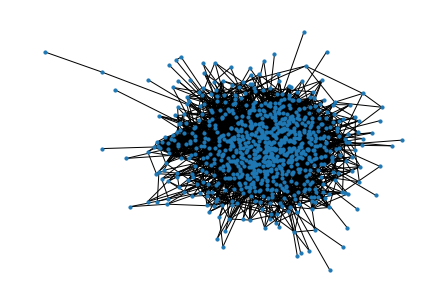

In [5]:
# create the graph
Gfacebook = nx.from_pandas_edgelist(df_facebook_friends, source="# user_a", target="user_b")

nx.draw(Gfacebook, node_size=10)

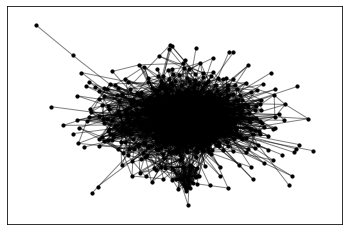

In [6]:
pos = nx.fruchterman_reingold_layout(Gfacebook)
nx.draw_networkx_nodes(Gfacebook, pos, node_size=10, node_color="black");
nx.draw_networkx_edges(Gfacebook, pos, alpha=0.500);
#nx.draw_networkx_labels(Gfacebook, pos, font_color="white");

In [7]:
from scipy.special import factorial
from scipy.optimize import curve_fit

def poisson(k, lambd):
    return(lambd**k/factorial(k))*np.exp(-lambd)

C:\Users\hp\AppData\Local\Temp\ipykernel_14588\34255599.py:5: RuntimeWarning: invalid value encountered in power
  return(lambd**k/factorial(k))*np.exp(-lambd)


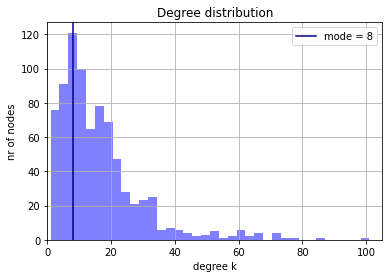

In [8]:
# degree distribution
import statistics
degree_sequence = np.array(sorted((d for n, d in Gfacebook.degree()), reverse=True))
#bin_edges = np.logspace(np.log10(degree_sequence.min()), np.log10(degree_sequence.max()), 10)
entries, bin_edges, patches = plt.hist(degree_sequence,bins=36,density=False,color='blue',alpha=0.5)#bins=bin_edges)

# calculate bin centres
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

popt, pcov = curve_fit(poisson, bin_middles, entries)

x_plot = np.arange(0, 36)
#plt.plot(x_plot,poisson(x_plot, popt),'bo')
plt.axvline(statistics.mode(degree_sequence),label='mode = '+str(statistics.mode(degree_sequence)),color='navy')
#plt.xscale('log')
#plt.yscale('log')
plt.title('Degree distribution')
plt.xlabel('degree k')
plt.ylabel('nr of nodes')
plt.xlim(0,105)
plt.legend()
plt.grid()
plt.savefig('plots/degFB')
plt.show()

In [9]:
degree_sequence

array([101,  86,  78,  74,  73,  72,  72,  71,  66,  65,  65,  65,  64,
        63,  62,  62,  62,  61,  60,  60,  59,  57,  56,  53,  53,  51,
        51,  51,  50,  49,  49,  48,  48,  45,  45,  44,  44,  42,  42,
        41,  41,  40,  40,  39,  39,  39,  39,  39,  39,  38,  37,  37,
        35,  35,  35,  35,  34,  34,  34,  34,  34,  34,  33,  33,  33,
        33,  33,  33,  33,  33,  33,  32,  32,  32,  32,  32,  32,  32,
        32,  32,  32,  31,  31,  31,  31,  31,  31,  31,  30,  30,  30,
        30,  30,  30,  30,  30,  30,  30,  30,  29,  29,  29,  29,  29,
        28,  28,  28,  27,  27,  27,  27,  27,  27,  26,  26,  26,  26,
        26,  26,  26,  26,  26,  26,  26,  26,  25,  25,  25,  25,  25,
        25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  24,  24,
        24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  23,  23,  23,
        23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  22,
        22,  22,  22,  22,  22,  22,  22,  22,  22,  22,  22,  2

non fitta poisson, descrescita esponenziale nel dubbio

In [10]:
for n, d in Gfacebook.degree():
    if d==101:
        print(n,d)
    elif d==86:
        print(n,d)

706 86
485 101


Negli altri dataset non emergono, son due sfigati asociali

Complementary Cumulative Degree Distribution

When plotting the complementary cumulative degree distribution, $P_k \sim k^{ -(\gamma-1)}$ \
$\to$ linear fit $(y=mx+q)$ where $\gamma=1-m$

m = -0.00029995129500564997 6.950645061698353e-10
q =  0.7259932140418024 3.3108753582332023e-06
gamma = 1.0


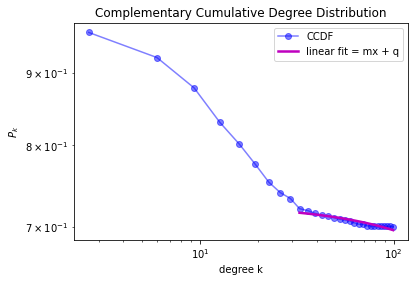

In [11]:
# CCDF
points, edg = np.histogram(degree_sequence,bins=30,density=True)

x = (edg[1:]+edg[:-1])*0.5
y = 1-np.cumsum(points)

# linear fit
def f(X,m,q):
    return X*m+q

popt, pcov = optimize.curve_fit(f,x[9:],y[9:])
gamma = 1-popt[0] 


# plot
plt.plot(x,y,'b-o',alpha=0.5,label='CCDF')
plt.plot(x[9:],f(x[9:],popt[0],popt[1]),'m-',linewidth=2.5,label='linear fit = mx + q')
print('m =' ,popt[0],pcov[0][0])
print('q = ',popt[1],pcov[1][1])
print('gamma =',np.round(gamma,2))
plt.title('Complementary Cumulative Degree Distribution')
plt.xlabel('degree k')
plt.ylabel(r'$P_k$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('plots/CCDFFB')
plt.show()

In [12]:
# network parameters

N = Gfacebook.number_of_nodes()
L = Gfacebook.number_of_edges()
k_mean = np.mean(degree_sequence)
d_mean = nx.average_shortest_path_length(Gfacebook)
d_mean_est = np.log2(N)/np.log2(k_mean)
d_max = nx.diameter(Gfacebook)
print('N=',N,' L=',L,' k_mean=',int(k_mean),' d_mean=',np.round(d_mean,2),
      ' d_mean_est=',np.round(d_mean_est,2),' d_max=',d_max)

N= 800  L= 6418  k_mean= 16  d_mean= 2.98  d_mean_est= 2.41  d_max= 7


In [13]:
np.round(np.log(800))/800

0.00875

In [14]:
nx.is_connected(Gfacebook)

True

##### Centrality measures
The **degree centrality** for a node v is the fraction of nodes it is connected to.\
The **eigenvector centrality** computes the centrality for a node based on the centrality of its neighbors.\
The **closeness centrality** of a node u is the reciprocal of the average shortest path distance to u over all n-1 reachable nodes.\
The **betweenness centrality** of a node v is the sum of the fraction of all-pairs shortest paths that pass through v

In [15]:
import matplotlib.colors as mcolors
def func_to_plot(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=10, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    cent = np.fromiter(measures.values(), float)
    nodes.set_norm(mcolors.Normalize(vmin=cent.min(), vmax=cent.max()))
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos,alpha=0.2)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [16]:
# nodes positioned using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(Gfacebook)

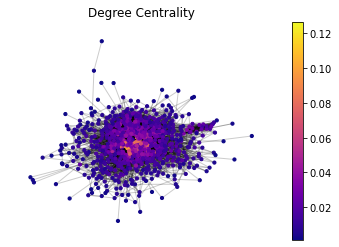

In [17]:
# degree centrality
DC = nx.degree_centrality(Gfacebook)
func_to_plot(Gfacebook, pos, DC, 'Degree Centrality')

In [18]:
# top ten and last ten
DCtopten = sorted(DC, key=DC.get, reverse=True)[:10]
DCbottomten = sorted(DC, key=DC.get, reverse=False)[:10]

# print top ten
for i in DCtopten:
    print(i,DC[i])

485 0.12640801001251564
706 0.10763454317897372
13 0.09762202753441802
733 0.09261576971214018
838 0.09136420525657071
324 0.09011264080100126
472 0.09011264080100126
263 0.08886107634543179
221 0.08260325406758448
52 0.08135168961201503


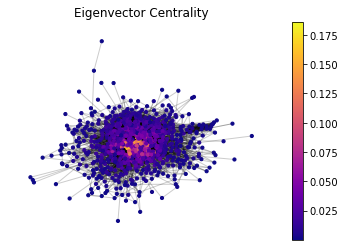

In [19]:
# eigenvector centrality
EC = nx.eigenvector_centrality(Gfacebook)
func_to_plot(Gfacebook, pos, EC, 'Eigenvector Centrality')

In [20]:
# top ten and last ten
ECtopten = sorted(EC, key=EC.get, reverse=True)[:10]
ECbottomten = sorted(EC, key=EC.get, reverse=False)[:10]

# print top ten
for i in ECtopten:
    print(i,EC[i])

485 0.18573269594989783
706 0.18360327568417165
13 0.1567490856560137
472 0.1563559096458721
75 0.1462477987634866
838 0.14491258161309672
263 0.1449035991851265
324 0.14451811839339226
733 0.14151500475349188
221 0.14122597593180408


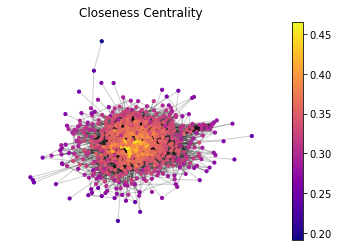

In [21]:
# closeness centrality
CC = nx.closeness_centrality(Gfacebook)
func_to_plot(Gfacebook, pos, CC, 'Closeness Centrality')

In [22]:
# top ten and last ten
CCtopten = sorted(CC, key=CC.get, reverse=True)[:10]
CCbottomten = sorted(CC, key=CC.get, reverse=False)[:10]

# print top ten
for i in CCtopten:
    print(i,CC[i])

706 0.46480511925538104
13 0.4645348837209302
485 0.46131639722863743
472 0.45787965616045845
733 0.45683247570040025
263 0.45090293453724606
176 0.45090293453724606
324 0.4483726150392817
521 0.44611948632049137
52 0.444629938786867


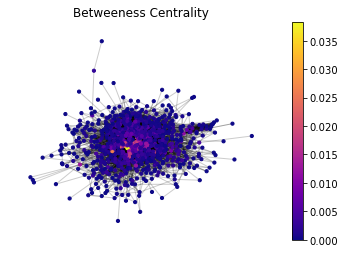

In [23]:
# betweeness centrality
BC = nx.betweenness_centrality(Gfacebook)
func_to_plot(Gfacebook, pos, BC, 'Betweeness Centrality')

In [24]:
# top ten and last ten
BCtopten = sorted(BC, key=BC.get, reverse=True)[:10]
BCbottomten = sorted(BC, key=BC.get, reverse=False)[:10]

# print top ten
for i in BCtopten:
    print(i,BC[i])

13 0.038225088235638915
485 0.03731986342529757
706 0.03554881413695769
324 0.02848765268019378
578 0.02688720421143541
733 0.026619980323726193
657 0.026222882193282487
263 0.023800845756492668
52 0.023154468888543573
81 0.022219172733915642


##### PageRank


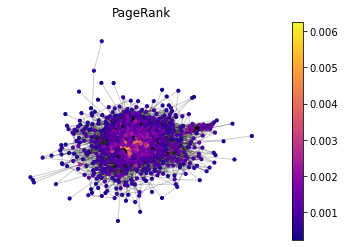

In [25]:
PR = nx.pagerank(Gfacebook, alpha=0.85)
func_to_plot(Gfacebook, pos, PR, 'PageRank')

In [26]:
# # top ten and last ten
PRtopten = sorted(PR, key=PR.get, reverse=True)[:10]
PRbottomten = sorted(PR, key=PR.get, reverse=False)[:10]

# print top ten
for i in PRtopten:
    print(i,PR[i])

485 0.006233567600646614
706 0.005375670332207295
13 0.005017475779677165
733 0.004692346222431574
324 0.004621690709077476
838 0.00451356571987314
472 0.004503275889159489
263 0.0044993159003908125
52 0.004295740119863544
300 0.004162609261910997


##### HITS

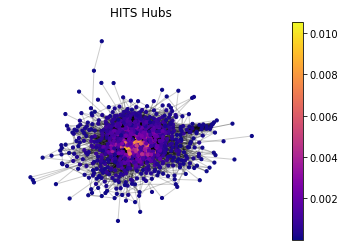

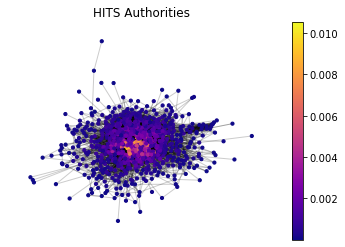

In [27]:
h,a = nx.hits(Gfacebook)
func_to_plot(Gfacebook, pos, h, 'HITS Hubs')
func_to_plot(Gfacebook, pos, a, 'HITS Authorities')

In [28]:
# top ten and last ten
atopten = sorted(a, key=a.get, reverse=True)[:10]
abottomten = sorted(a, key=a.get, reverse=False)[:10]

# print top ten
for i in atopten:
    print(i,a[i])

485 0.010518357166658472
706 0.010397994444022458
13 0.00887690002432889
472 0.008854596783058593
75 0.00828253874681466
838 0.008207005842200169
263 0.008206278819342838
324 0.008184411137316782
733 0.008014055115051677
221 0.007998163930818572


##### Comparison between centrality measures (top10 and last10)

In [29]:
# top 10
unique_topten = np.unique(sorted(DCtopten)+sorted(ECtopten)+sorted(CCtopten)+sorted(BCtopten)+sorted(PRtopten)+sorted(atopten))
print(unique_topten)

list_of_lists_top = [sorted(DCtopten),sorted(ECtopten),sorted(CCtopten),sorted(BCtopten),sorted(PRtopten),sorted(atopten)]

counts_top = []
for i in unique_topten:
    count = 0
    for l in list_of_lists_top:
        if i in l:
            count += 1
        else:
            pass
    counts_top.append(count)
print(counts_top)

[ 13  52  75  81 176 221 263 300 324 472 485 521 578 657 706 733 838]
[6, 4, 2, 1, 1, 3, 6, 1, 6, 5, 6, 1, 1, 1, 6, 6, 4]


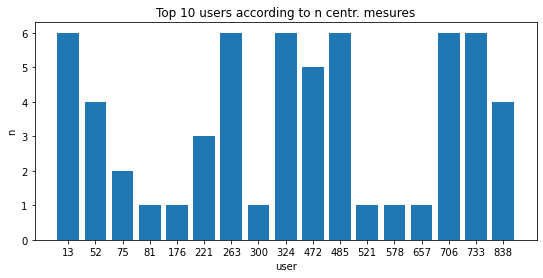

In [30]:
# histo
plt.figure(figsize=(9,4))
plt.bar(np.arange(len(unique_topten)),counts_top,tick_label=unique_topten)
plt.xlabel('user')
plt.ylabel('n')
plt.title('Top 10 users according to n centr. mesures')
plt.show()

$\to$ the 6 centrality measures analyzed totally agree on having on the top 10 the following users:


In [31]:
# bottom 10
unique_bottomten = np.unique(sorted(DCbottomten)+sorted(ECbottomten)+sorted(CCbottomten)
                             +sorted(BCbottomten)+sorted(PRbottomten)+sorted(abottomten))
print(unique_bottomten)

list_of_lists_bottom = [sorted(DCbottomten),sorted(ECbottomten),sorted(CCbottomten),sorted(BCbottomten),sorted(PRbottomten),sorted(abottomten)]

counts_bottom = []
for i in unique_bottomten:
    count = 0
    for l in list_of_lists_bottom:
        if i in l:
            count += 1
        else:
            pass
    counts_bottom.append(count)
print(counts_bottom)

[ 45  77  98 125 150 264 361 420 434 459 495 516 548 565 592 629 680 697
 704 705 710 730 765 767 769 783 810 825]
[3, 2, 3, 1, 1, 2, 1, 5, 2, 1, 3, 5, 2, 3, 3, 2, 1, 2, 3, 3, 1, 1, 3, 2, 1, 2, 1, 1]


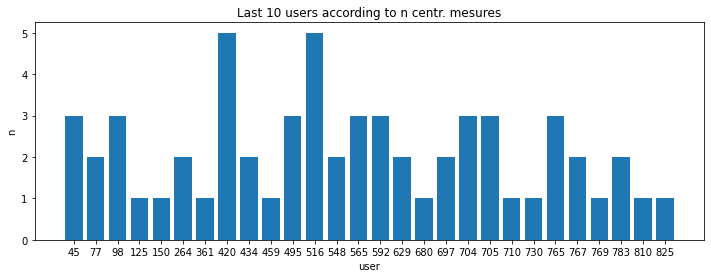

In [32]:
# histo
plt.figure(figsize=(12,4))
plt.bar(np.arange(len(unique_bottomten)),counts_bottom,tick_label=unique_bottomten)
plt.xlabel('user')
plt.ylabel('n')
plt.title('Last 10 users according to n centr. mesures')
plt.show()

Only users 420 and 516 are present in the last 10 for each of the 6 centrality measures considered. The majority is n=3, are they the same measures? (To see which measures are more similar)

##### Community detection
For the community detection task we use the Girvan-Newman algorithm. It relies on the iterative elimination of edges that have the highest number of shortest paths between nodes passing through them. By removing edges from the graph one-by-one, the network breaks down into smaller pieces, so-called communities.


In [33]:
from networkx.algorithms.community.centrality import girvan_newman

communities = girvan_newman(Gfacebook)

node_groups = []
for com in next(communities):
    node_groups.append(list(com))

color_map = []
for node in Gfacebook:
    
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('orange')  
        
nx.draw_networkx_nodes(Gfacebook, node_size=10, node_color=color_map)


TypeError: draw_networkx_nodes() missing 1 required positional argument: 'pos'

In [ ]:
# import networkx.algorithms.community.quality as p
# communities = girvan_newman(Gfacebook)
# p.partition_quality(Gfacebook,communities)

As we can see from the plot, according to the Girvan-Newman algorithm we have only two distinct communities: one composed of the majority of the nodes, the other with the two nodes corresponding to the user nr 98 and 495.

Sono users che mandano pochi messaggi in generale, tra i pochi destinatari ci son proprio loro e 420, 362 che è in fondo alla classifica, sono strongly connected e sono una community in sms, e in chiamate senza 362


In [34]:

import networkx.algorithms.community as nx_comm

nx_comm.louvain_communities(Gfacebook)

AttributeError: module 'networkx.algorithms.community' has no attribute 'louvain_communities'

##### Preferential attachment
ritorna score per ogni coppia, capirne come usarli

In [ ]:
# preferential attachment score
preds = nx.preferential_attachment(Gfacebook)

df_scores = pd.DataFrame(preds,columns=['node1','node2','pa_score'])


In [ ]:
df_scores.sort_values(by=['pa_score'],ascending=False)

In [ ]:
df_scores[df_scores['node1']==485]

## Assortativity

In [ ]:
from scipy import stats

In [ ]:
G_calls = Gfacebook

y = nx.average_neighbor_degree(G_calls)
x = nx.degree(G_calls)

X = []
Y = []

for k in y.keys():
    X.append(x[k])
    Y.append(y[k])
    
    
res = stats.linregress(X, Y)
x = np.arange(min(X),max(X),0.1)

plt.plot(X,Y,'o',alpha=0.1)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k_{nn}$',fontsize=15)

plt.plot(x,x*res.slope + res.intercept,'r-',linewidth =3)
txt = r'SLOPE: $'+str(res.slope)[:4] + '\pm '+ str(res.stderr)[:4] +'> 0$'
plt.text(45,15,txt,fontsize=14 ,color= 'red')
plt.title('Assortativity')
plt.grid()
plt.savefig('plots/assortFB')
plt.show()



In [ ]:
f = plt.imshow(nx.degree_mixing_matrix(Gfacebook),origin='lower',cmap='Blues')
plt.colorbar(f)
plt.title('Mixing matrix')
plt.xlabel('k1')
plt.ylabel('k2')
plt.savefig('plots/mixmatrFB')
plt.show()